In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
#from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
%matplotlib inline

# Question 1

### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Loading the data

In [2]:
data = pd.read_csv('lalonde.csv', index_col=0)

data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### Data split
To do our naive aproach, we split our data regarding if the subject participated in the job training program or not.

In [3]:
treated_group = data[data['treat'] == 1]
untreated_group = data[data['treat'] == 0]

In [4]:
treated_desc = treated_group['re78'].describe().rename("Treated")
treated_desc.set_value('median', treated_group['re78'].median())

untreated_desc = untreated_group['re78'].describe().rename("Unreated")
untreated_desc.set_value('median', untreated_group['re78'].median())

stats_df = pd.concat([treated_desc, untreated_desc], axis=1)
stats_df

,Treated,Unreated
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000
median,4232.309000,4975.505000


#### Some observations:
- The max earning value for the treated group is way higher than the max earning for the untreated group, but the mean and median values are higher for the untreated group, which leads us to think that the treated group overall didn't get better results, even though some outliers did get a very good outcome from the trainee program. We can also observe the higher standard deviation for the treated group, which goes in the same direction.

Now lets display some plots of the distribution to visually see what it looks like.

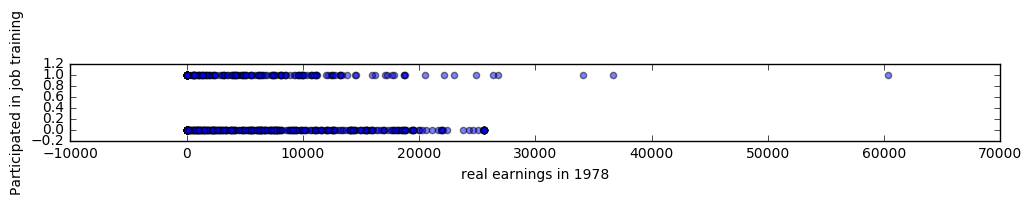

In [5]:
plt.figure(figsize=(12,1))
plt.scatter(data['re78'], data['treat'], alpha=0.5)
plt.xlabel('real earnings in 1978')
plt.ylabel('Participated in job training')

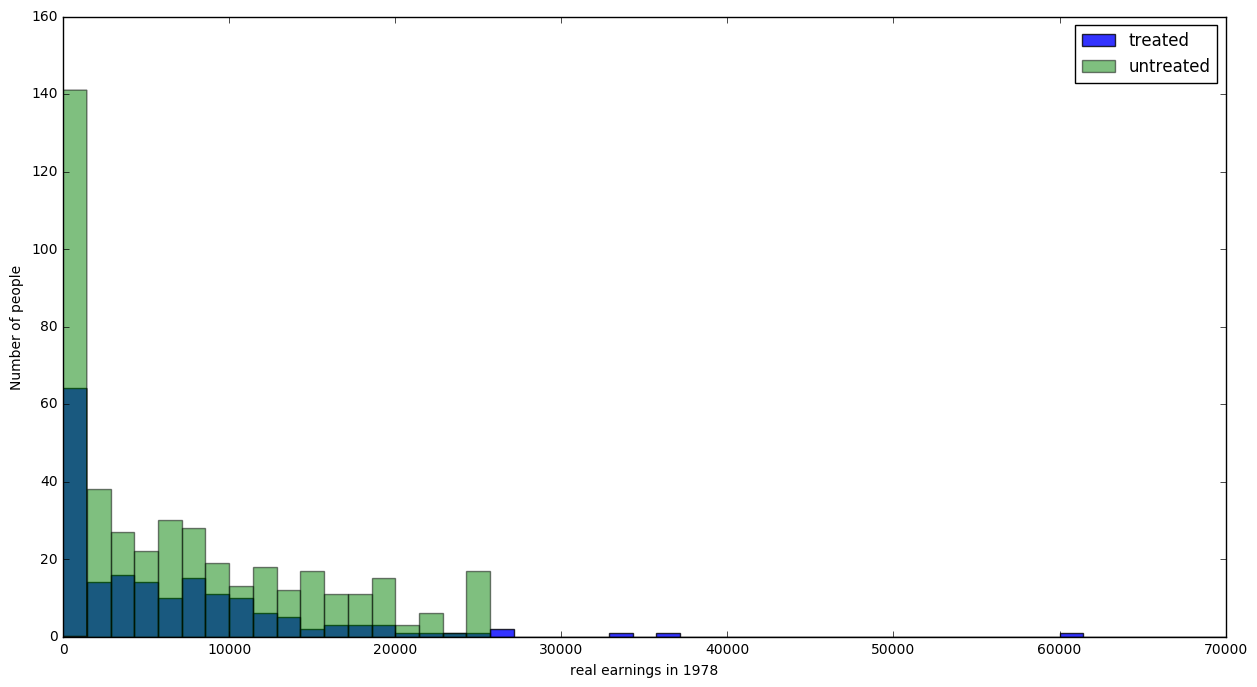

In [6]:
bins = np.linspace(0,70000, 50)

plt.figure(figsize=(15,8))
plt.hist(treated_group['re78'], bins, alpha=0.8, label='treated')
plt.hist(untreated_group['re78'], bins, alpha=0.5, label='untreated')
plt.legend(loc='upper right')
plt.xlabel('real earnings in 1978')
plt.ylabel('Number of people')
plt.show()

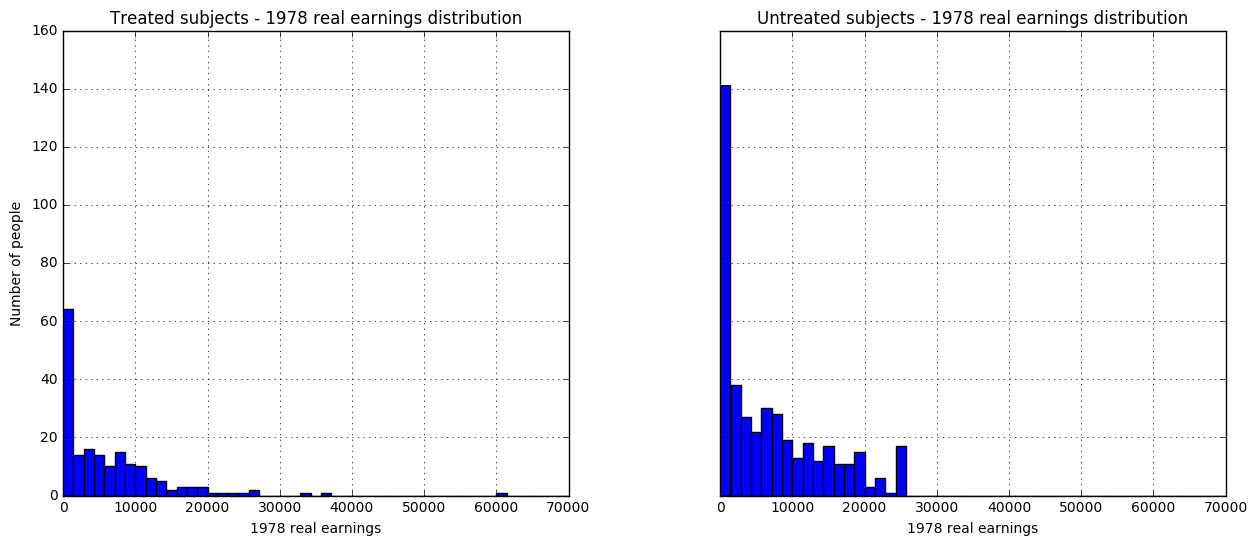

In [7]:
def draw_hists(data1, data2, title, xlabel, ylabel, column):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)
    data1.hist(column, bins=bins, label='treated', ax=ax1)
    data2.hist(column, bins=bins, label='untreated', ax=ax2)
    set_axis(ax1, True, title, xlabel)
    set_axis(ax2, False, title, xlabel)
    ax1.set_ylabel(ylabel)

def set_axis(ax, treated, title, xlabel=None):
    if treated:
        ax.set_title('Treated '+ title)
    else:
        ax.set_title('Untreated ' + title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    return


draw_hists(treated_group, untreated_group, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')

#TODO create function and set all configs for axis etc. for both histograms # Complete?

#### Conclusion on our naive analisis

We can directly notice two big difference between the two groups:
- The untreated group has a larger and flatter distribution on the earning. And it deacrise less than the treated group.
- There exist a few very high earning on the treated group.

Both groups appears to have a quit similar plot. However, regarding the median and the mean, the untreated groups seems to have a higher value of income.
##### mean
- Treated 	6349.143530
- Untreated 6984.169742

##### median 	 	
- Treated 	4232.309000
- Untreated 4975.505000

In conclusion of this naive analisi, we can say that the trainging program don't work. It only give the possibility to a tiny part to earn the jacpot.

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [8]:
treated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [9]:
untreated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


It's always easier to look at pictures than numbers, so let us start with continious data of age and years of education. We will build the box plots to observe that the treated group is generally younger and that the distribution of years of education is similar, except that the untreated group has a couple of outliers more.

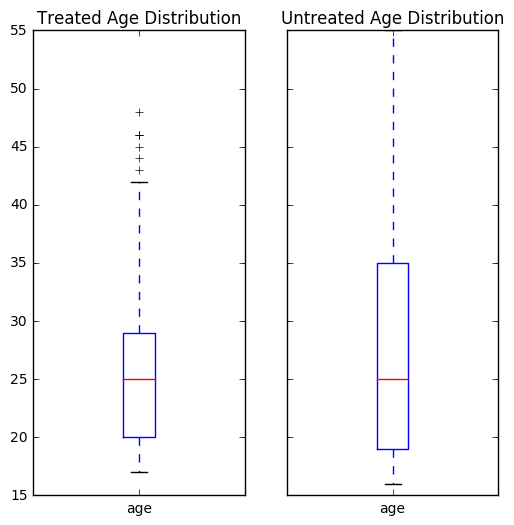

In [10]:
def drawBoxPlot (data1, data2, title, col):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,6), sharex=True, sharey=True)
    treated_group[col].plot.box(ax=ax1)
    untreated_group[col].plot.box(ax=ax2)
    set_axis(ax1, True, title)
    set_axis(ax2, False, title)

drawBoxPlot(treated_group, untreated_group, 'Age Distribution', 'age')

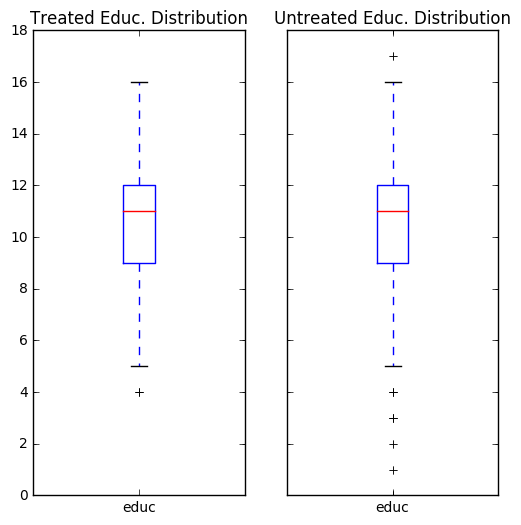

In [11]:
drawBoxPlot(treated_group, untreated_group, 'Educ. Distribution', 'educ')

Now let's have a look at the distribution of real earnings before the treatment.

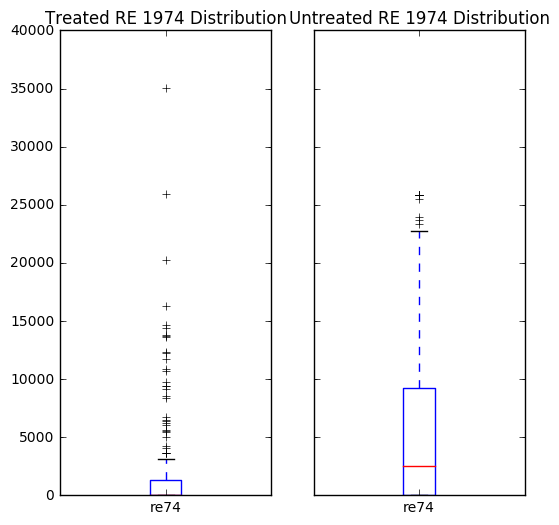

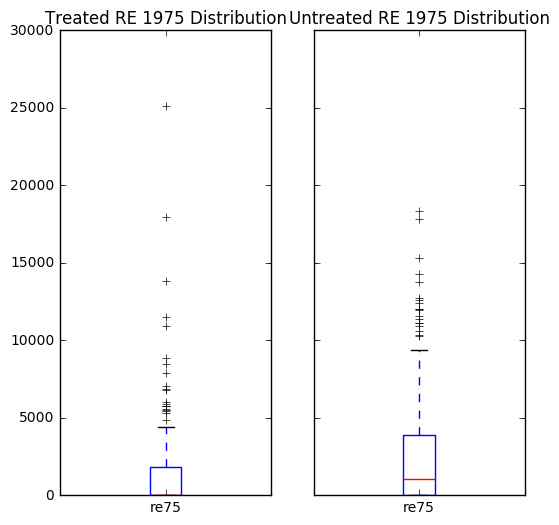

In [12]:
drawBoxPlot(treated_group, untreated_group, 'RE 1974 Distribution', 're74')
drawBoxPlot(treated_group, untreated_group, 'RE 1975 Distribution', 're75')

Here is something interesting: before the trearment the treated group was earning significantly less then untreated group. Moreover there are a couple of outliers in the treated group that earned a lot more then the mean of the group, that might explain the outliers in the real earnings distribution after the treatment.

Below, we compare the percent of true/false values for features concerning race ('black' and 'hispan'), marriage and degree for each group and compare in bar charts.

We also plot the distributions for the age, education and income prior to the experience to compare between the two groups.

These observations will let us determine if the two groups are equivalently distributed.

black percent for treated group: 84.32%
black percent for untreated group: 20.28%



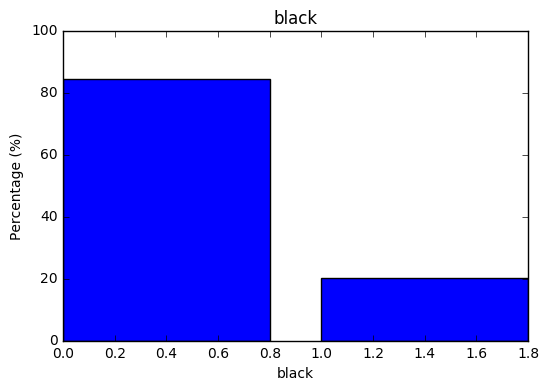

hispan percent for treated group: 5.95%
hispan percent for untreated group: 14.22%



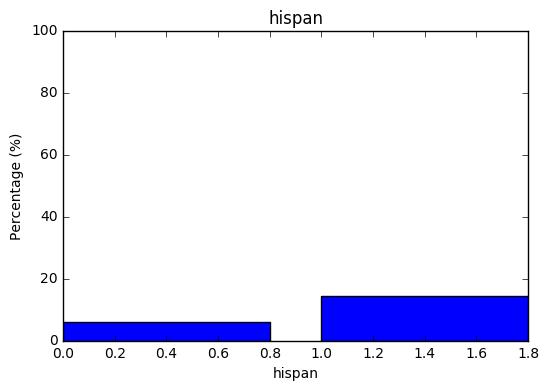

married percent for treated group: 18.92%
married percent for untreated group: 51.28%



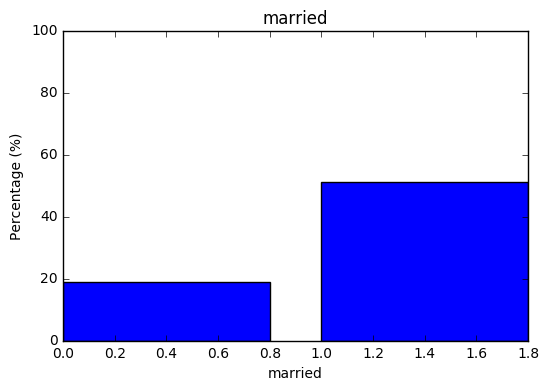

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 59.67%



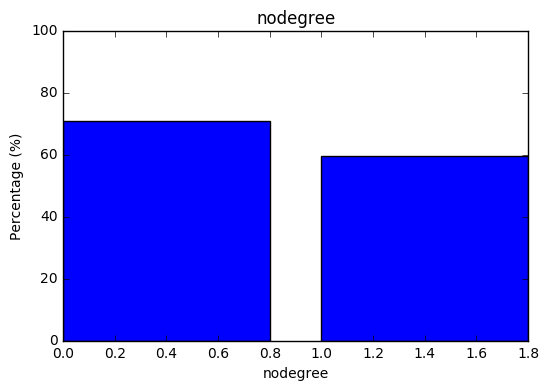

[None, None, None, None]

In [13]:
def percentage_comparison(treated_g, untreated_g, feature):
    treated_percent = 100 * np.sum(treated_g[feature]) / treated_g[feature].size
    untreated_percent = 100 * np.sum(untreated_g[feature]) / untreated_g[feature].size
    print('{} percent for treated group: {:0.2f}%'.format(feature, treated_percent))
    print('{} percent for untreated group: {:0.2f}%'.format(feature, untreated_percent))
    print()
    
    x = [u'True', u'False']
    y = [treated_percent, untreated_percent]
    fig, ax = plt.subplots() 
    plt.bar([0,1], [treated_percent, untreated_percent])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Percentage (%)')
    
    ax.set_ylim([0,100])
    
    plt.show()

features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(treated_group, untreated_group, f) for f in features_to_compare]

# TODO plot values above in small bar charts with yaxis 100% to compare visually
# TODO plot in subplots side by side, nicer
# Display bar value in each bar
# TODO plot age distribution, plot years of education, display income before exp
# TODO box plots?
# TODO new column with 'race_other' (if black and hispan == 0)

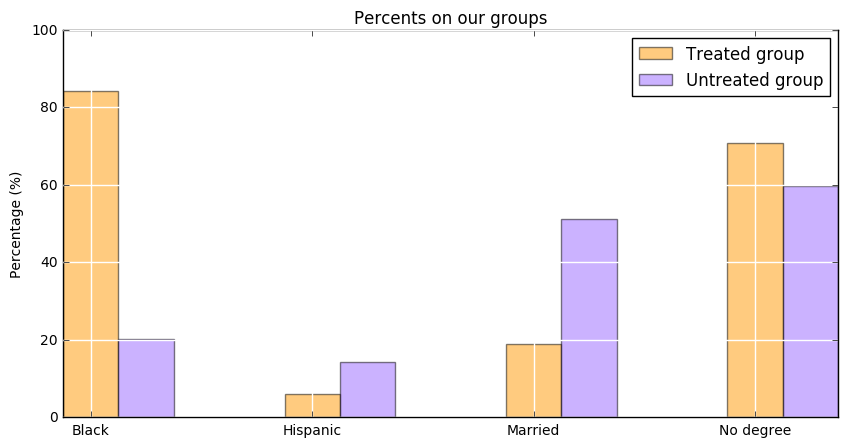

In [14]:
#create two dataset for the percent
temp_data = {
    'categories':['Black', 'Hispanic', 'Married', 'No degree'],
    'Treated':  [100 * np.sum(treated_group['black']) / treated_group['black'].size,
                 100 * np.sum(treated_group['hispan']) / treated_group['hispan'].size,
                 100 * np.sum(treated_group['married']) / treated_group['married'].size,
                 100 * np.sum(treated_group['nodegree']) / treated_group['nodegree'].size],
    'Untreated': [100 * np.sum(untreated_group['black']) / untreated_group['black'].size,
                  100 * np.sum(untreated_group['hispan']) / untreated_group['hispan'].size,
                  100 * np.sum(untreated_group['married']) / untreated_group['married'].size,
                  100 * np.sum(untreated_group['nodegree']) / untreated_group['nodegree'].size]  
}

percent_df = pd.DataFrame(temp_data, columns = ['categories', 'Treated', 'Untreated'])

# Setting the positions and width for the bars
pos = list(range(len(percent_df['Treated']))) 
width = 0.25 

# Creating the plot of both groups
fig, ax = fig, ax = plt.subplots(figsize=(10,5))

plt.bar(pos, 
        percent_df['Treated'], 
        width, 
        alpha=0.5, 
        color='#ff9900')

plt.bar([ p + width for p in pos ], 
        percent_df['Untreated'], 
        width, 
        alpha=0.5, 
        color='#9966ff')

ax.set_ylabel('Percentage (%)')
ax.set_title('Percents on our groups')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(percent_df['categories'])
plt.ylim([0, 100])
plt.legend(['Treated group', 'Untreated group'], loc='upper right')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()

- Proportionally, the number of blacks in the control group is way higher than in the treated group.
- There is also a disreptancy in the percentage of married people in each group


These observations show that the treatment assignment isn't random and there is a huge bias between the two groups in some of the covariates, such as the number of blacks. This doesn't correspond to a randomized experiment. Such disruptancies cause major differences in the groups, which alone is enough to invalidate the naive conclusions made in part 1, or at least put the above findings into question.

### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [15]:
logistic = LogisticRegression()

confounders = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

y = data['treat']
X = data[confounders]
logistic.fit(X, y)

prop_score = [e for (_,e) in logistic.predict_proba(X)]

data['prop_score'] = prop_score
data.head()

# TODO way to ignore re74 and re75 when zero?

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


Which means, for example, that the second person in the above array has a 14.5% chance of being in the treated group.

### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [16]:
treat_prop = data[data['treat'] == 1]['prop_score']
untreat_prop = data[data['treat'] == 0]['prop_score']

#B = nx.complete_bipartite_graph(treat_prop.size, untreat_prop.size)

B = nx.Graph()

B.add_nodes_from(treat_prop.index, bipartite=0)
B.add_nodes_from(untreat_prop.index, bipartite=1)

for l_idx, l in treat_prop.iteritems():
    for r_idx, r in untreat_prop.iteritems():
        w = abs(l - r)
        B.add_edge(l_idx, r_idx, weigth=w)

max_matching = nx.max_weight_matching(B, True)
max_matching

# TODO is this matching correct? Histogram seems fishy, too many high values??

{'NSW1': 'PSID268',
 'NSW10': 'PSID252',
 'NSW100': 'PSID202',
 'NSW101': 'PSID388',
 'NSW102': 'PSID104',
 'NSW103': 'PSID47',
 'NSW104': 'PSID266',
 'NSW105': 'PSID69',
 'NSW106': 'PSID164',
 'NSW107': 'PSID348',
 'NSW108': 'PSID276',
 'NSW109': 'PSID162',
 'NSW11': 'PSID133',
 'NSW110': 'PSID171',
 'NSW111': 'PSID85',
 'NSW112': 'PSID300',
 'NSW113': 'PSID235',
 'NSW114': 'PSID25',
 'NSW115': 'PSID193',
 'NSW116': 'PSID3',
 'NSW117': 'PSID111',
 'NSW118': 'PSID380',
 'NSW119': 'PSID154',
 'NSW12': 'PSID45',
 'NSW120': 'PSID416',
 'NSW121': 'PSID200',
 'NSW122': 'PSID357',
 'NSW123': 'PSID96',
 'NSW124': 'PSID68',
 'NSW125': 'PSID12',
 'NSW126': 'PSID391',
 'NSW127': 'PSID205',
 'NSW128': 'PSID359',
 'NSW129': 'PSID121',
 'NSW13': 'PSID254',
 'NSW130': 'PSID353',
 'NSW131': 'PSID203',
 'NSW132': 'PSID234',
 'NSW133': 'PSID251',
 'NSW134': 'PSID302',
 'NSW135': 'PSID207',
 'NSW136': 'PSID250',
 'NSW137': 'PSID287',
 'NSW138': 'PSID185',
 'NSW139': 'PSID226',
 'NSW14': 'PSID192',
 'NSW

To check how good our matching performed, we compute the absolute difference between the two propensity scores for each pair in the matching and display a histogram of all the values.

In [17]:
'''def get_scores(matching):
    (left, _) = bipartite.sets(B)
    return [abs(treat_prop[l] - untreat_prop[matching[l]]) for l in left]

abs_diffs = get_scores(max_matching)
print('Mean absolute propensity score: {}'.format(np.mean(abs_diffs)))

plt.hist(abs_diffs,bins=25)
plt.title('Histogram of absolute propensity score difference for each pair in the matching')
plt.xlabel('absolute difference in propensity score')
plt.ylabel('# of elements')
plt.show()'''

"def get_scores(matching):\n    (left, _) = bipartite.sets(B)\n    return [abs(treat_prop[l] - untreat_prop[matching[l]]) for l in left]\n\nabs_diffs = get_scores(max_matching)\nprint('Mean absolute propensity score: {}'.format(np.mean(abs_diffs)))\n\nplt.hist(abs_diffs,bins=25)\nplt.title('Histogram of absolute propensity score difference for each pair in the matching')\nplt.xlabel('absolute difference in propensity score')\nplt.ylabel('# of elements')\nplt.show()"

As we can see, the algorithm found many good matchings, but there is a lot of pairs that have a big difference in propensity score, due to the fact that strictly each score has to be matched with one from the other group.

In [18]:
#left side is the treated nodes, right side is untreated nodes (size)
(left, right) = bipartite.sets(B)

print('Left (treated): {}'.format(len(left)))
print('Right (untreated): {}'.format(len(right)))

Left (treated): 185
Right (untreated): 429


The left side of the bipartite graph is the smallest, thus the matching contains all nodes on the left side (185) and has matched with 185 nodes on the right side (untreated patients).

In [19]:
'''treated_matched_index = left #are all matched
untreated_matched_index = [max_matching[l] for l in left]
len(untreated_matched_index)

# Get only the matched proensity scores for each group
matched_treated_group = data.loc[treated_matched_index]
matched_untreated_group = data.loc[untreated_matched_index]

draw_hists(matched_treated_group, matched_untreated_group, 'subjects - 1978 real earnings distribution', 
          '1978 real earnings', 'Number of people', 're78')'''

"treated_matched_index = left #are all matched\nuntreated_matched_index = [max_matching[l] for l in left]\nlen(untreated_matched_index)\n\n# Get only the matched proensity scores for each group\nmatched_treated_group = data.loc[treated_matched_index]\nmatched_untreated_group = data.loc[untreated_matched_index]\n\ndraw_hists(matched_treated_group, matched_untreated_group, 'subjects - 1978 real earnings distribution', \n          '1978 real earnings', 'Number of people', 're78')"

Now, with the propensity score matching, we have an observational study and looking at the results of 1978 earnings, we could conclude that the treatment did work well for the outliers that earned a lot more than the rest. There is also less people with no income in the treated group.

In [20]:
'''features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(matched_treated_group, matched_untreated_group, f) for f in features_to_compare]
'''
# TODO other features, like above

"features_to_compare = ['black', 'hispan', 'married', 'nodegree']\n[percentage_comparison(matched_treated_group, matched_untreated_group, f) for f in features_to_compare]\n"


Even though the number of blacks, for example, is still relatively different in each group, the differences are smaller for each feature and the groups look better distributed.

### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [21]:
# TODO

### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [22]:
# TODO

## Question 2: Applied ML
We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


### 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency-inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [23]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import column_or_1d
from sklearn import linear_model
import seaborn as sb

#### Loading the data
We directly load the data using sklearn. Then convert them into vector to path them into our random forest later on.

In [24]:
newsgroups = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer()
newsgroups.vectors = vectorizer.fit_transform(newsgroups.data)
print('Set shape:', newsgroups.vectors.shape)

Set shape: (18846, 173762)


#### spliting the data
We split the data according to the assignement, 10% for the test set.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(newsgroups.vectors, newsgroups.target, test_size=0.1)

### 2. 
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [26]:
SCORING = ['accuracy', 'neg_mean_squared_error']
def runCV(clf, X_train, y_train, k):
    scores = cross_validate(clf, X_train, y_train, cv=k, scoring=SCORING, return_train_score=False)
    print_scores(scores)
    return scores
        
def print_scores(scores):
    print('Scores')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(-scores['test_neg_mean_squared_error']).mean(), scores['test_neg_mean_squared_error'].std() * 2))
    

#### Try to fine-tune
We implemented our method to test different fine-tuning
# TODO find the shap errore on this function, or continue to use by hand value

In [27]:
'''def fine_tuning(depths, estimators):
    best_depth = 0;
    best_estimators = 0;
    best_acc = 0;

    for max_depth in depths:
        for n_estimators in estimators:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                n_jobs=-1
            )
            scores = runCV(clf, X_train, newsgroups_train.target, 7)
            acc = scores['test_accuracy'].mean()

            if acc > best_acc:
                best_depth = max_depth
                best_estimators = n_estimators
                best_acc = acc
                
    print('Best parameters are (accuracy of', best_acc, '):')
    print('Depth:', best_depth, 'n_estimators:', best_estimators)
    
    return best_depth, best_estimators

fine_tuning([10, 20, 30, 50, 70, 90, 100, 120, 150], [50, 150, 200, 300, 350, 400, 450, 500, 550])'''

"def fine_tuning(depths, estimators):\n    best_depth = 0;\n    best_estimators = 0;\n    best_acc = 0;\n\n    for max_depth in depths:\n        for n_estimators in estimators:\n            clf = RandomForestClassifier(\n                n_estimators=n_estimators,\n                max_depth=max_depth,\n                random_state=42,\n                n_jobs=-1\n            )\n            scores = runCV(clf, X_train, newsgroups_train.target, 7)\n            acc = scores['test_accuracy'].mean()\n\n            if acc > best_acc:\n                best_depth = max_depth\n                best_estimators = n_estimators\n                best_acc = acc\n                \n    print('Best parameters are (accuracy of', best_acc, '):')\n    print('Depth:', best_depth, 'n_estimators:', best_estimators)\n    \n    return best_depth, best_estimators\n\nfine_tuning([10, 20, 30, 50, 70, 90, 100, 120, 150], [50, 150, 200, 300, 350, 400, 450, 500, 550])"

We found some good fine tuning with:
- max_depth = 100
- n_estimators = 400

In [34]:
max_depth = 100
n_estimators = 400

#### Building the classifier

In [35]:
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Model assessment

In [30]:
predict = clf.predict(X_test)
accuracy = accuracy_score(y_test, predict)
accuracy

0.87161803713527852

Our accuracy reach 87%. A Really decent result!

#### Some viualisation:

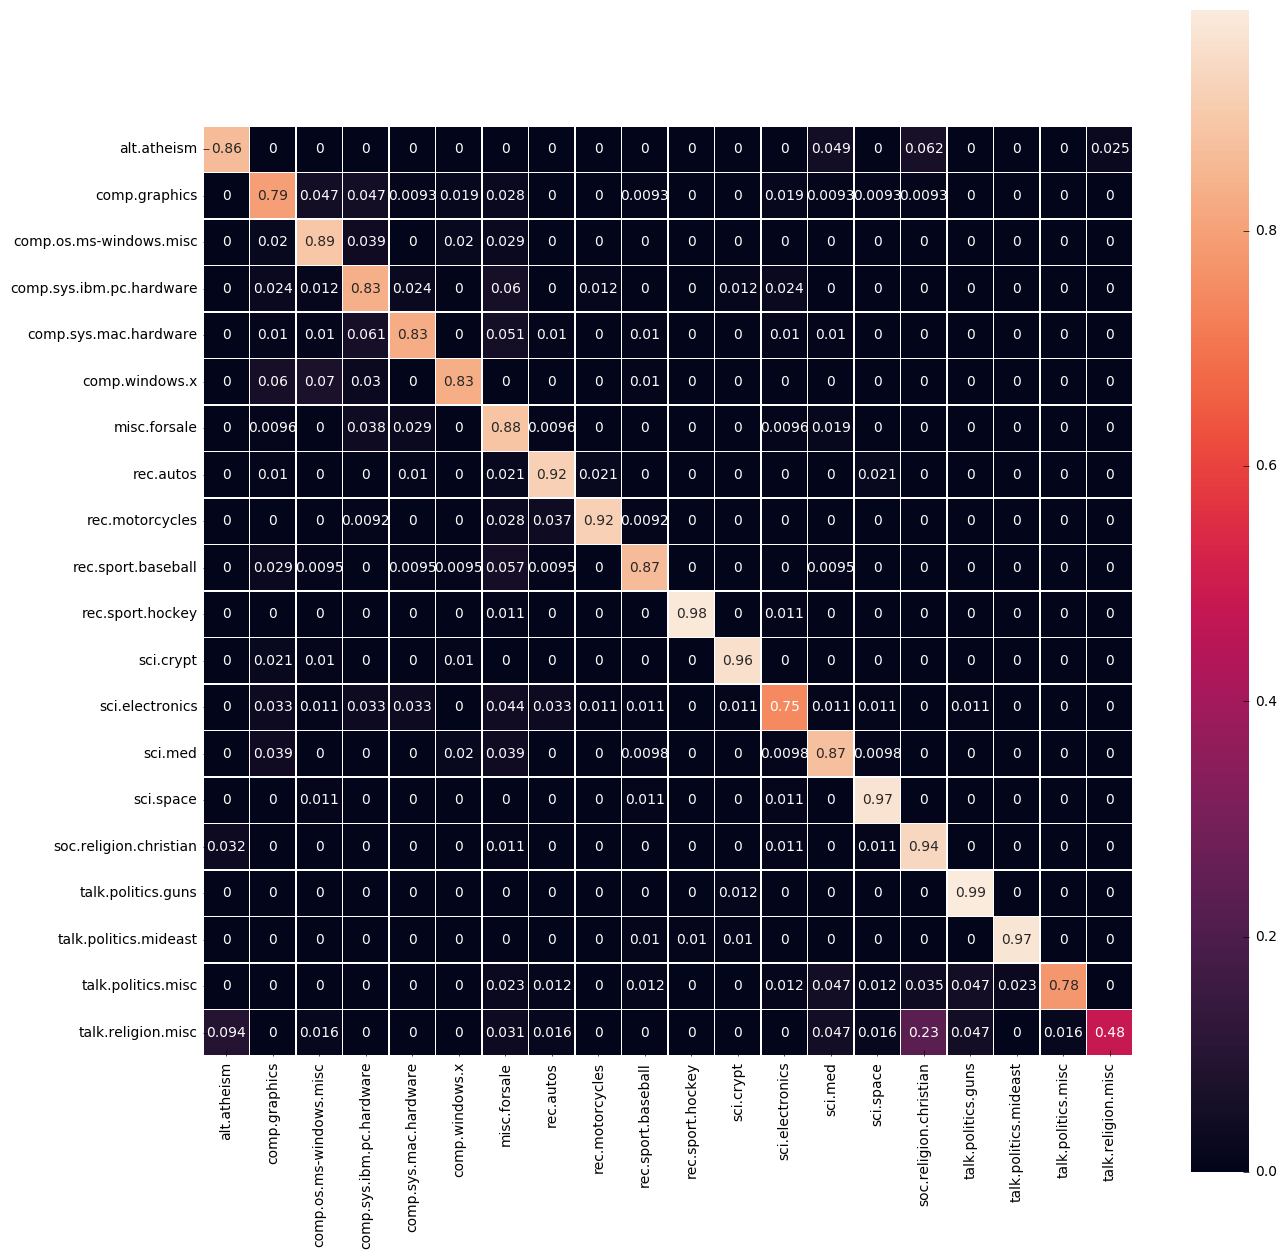

In [31]:
conf_matrix = confusion_matrix(y_test, predict)
conf_matrix = pd.DataFrame(conf_matrix, index=newsgroups.target_names, columns=newsgroups.target_names)
conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
plt.figure(figsize=(15, 15))
sb.heatmap(conf_matrix, square=True, annot=True, linewidths=0.1)
plt.show()

#### Info about the feature

In [32]:
sorted_features = np.flip(np.sort(clf.feature_importances_), axis=0)
sorted_features

array([ 0.00502049,  0.00478323,  0.00478026, ...,  0.        ,
        0.        ,  0.        ])

In [33]:
np.count_nonzero(sorted_features == 0)

89628

We see that there is a big part of feature with no importances. Those are not used to classify the articles. Those corresponding to very common and frenquent ford such as 'the'. We can then imagin a method to supress those featur and speed up our process.

### Conclusion on part 2
We learn how to build a decent articles classifier with 87% of accuracy using test and validation set in practice, using crossing validation and random forest! Anyway, the computation take some times, and as  we saw on the feature analysis, we could spare some with taking some precaution on the feature we use.